In [ ]:
!pip install -U scikit-learn
!pip install pandas
!pip install numpy
!pip install matplotlib

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Initially used numpy for reading csv but it gave error at line 38 because there was a comma. So i guess it is not for reading text. therefore used pandas.

In [42]:
# train data
tdf = pd.read_csv("CompleteDataset.csv", sep="|")
# test data
#vdf = pd.read_csv('defects.csv')
tdf = tdf.sample(frac = 1, random_state=1).reset_index()
#print(tdf.head)

vdf = tdf.iloc[30400:]
tdf = tdf.iloc[:30400]

print(tdf.head)
print(vdf.head)

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2


<bound method NDFrame.head of        index                                            summary  \
0      12922          Translation Error in Shipping Information   
1       2967  Failure in integrating the new billing module ...   
2      37519  Certain fonts or icons are missing or displaye...   
3      23768  Customer Management's State pattern lacks entr...   
4      13244           Resource configuration error in settings   
...      ...                                                ...   
30395  10417  Flawed Algorithm Causes Unexpected Service Una...   
30396  31819  Web service calls were rejected due to invalid...   
30397   7028  Deployment failed due to an error in Heroku Pr...   
30398  31702  The online multiplayer game is not supporting ...   
30399   2652  Frequent re-rendering of UI components leading...   

                   category                super  
0         Translation Error             UI Error  
1         Integration Error    Integration Error  
2           

Get number of samples and words per sample to compare. Then using https://developers.google.com/machine-learning/guides/text-classification/step-2-5 decide to the model.

In [ ]:
rows = len(df)
total_words = df['summary'].apply(lambda x: len(str(x).split())).sum()
w_per_s = total_words / rows
w_per_s

10.276476471207495

Since it is less than 1500 we are going with MLP.

In [ ]:
def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

Berfore we fed model with data. We should tokenize.

['Algorithmic Error' 'Build Error' 'Communication Error'
 'Data Management Error' 'Deployment Error' 'Design Error'
 'Integration Error' 'Logging Error' 'Migration Error' 'Patching Error'
 'Performance Error' 'Resource Error' 'Security Error'
 'Specification Error' 'System Error' 'Testing Error' 'UI Error'
 'Validation Error' 'Verfigback Error']


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:2072: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


0.9289380181602842


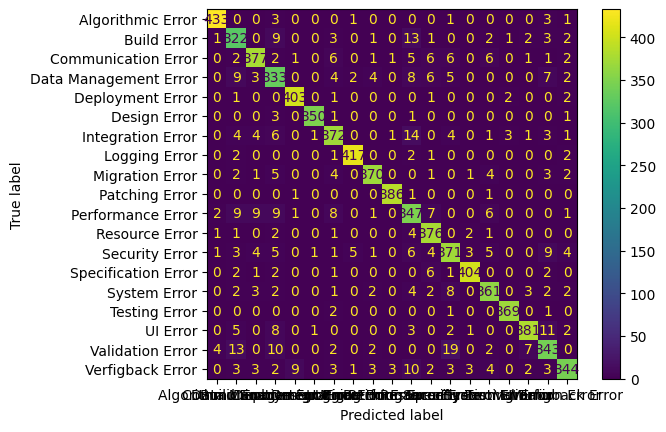

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       442
           1       0.85      0.89      0.87       360
           2       0.93      0.90      0.92       417
           3       0.83      0.87      0.85       383
           4       0.97      0.98      0.98       410
           5       0.99      0.98      0.99       356
           6       0.91      0.90      0.90       415
           7       0.98      0.98      0.98       425
           8       0.96      0.94      0.95       393
           9       0.99      0.99      0.99       389
          10       0.83      0.87      0.85       400
          11       0.91      0.97      0.94       388
          12       0.88      0.88      0.88       423
          13       0.98      0.96      0.97       419
          14       0.92      0.92      0.92       392
          15       0.98      0.99      0.99       373
          16       0.96      0.92      0.94       414
          17       0.88    

In [43]:
# Define train_texts, train_labels, val_texts, and val_labels earlier
train_texts = tdf['summary']
train_labels = tdf['super']
val_texts = vdf['summary']
val_labels = vdf['super']
# Initialize a label encoder
label_encoder = LabelEncoder()

# Fit the encoder on the training labels and transform both train and validation labels

y_train_encoded = label_encoder.fit_transform(train_labels)
y_val_encoded = label_encoder.transform(val_labels)
unique_classes = label_encoder.classes_

print(unique_classes)

# Vectorize the texts using the function
x_train, x_val = ngram_vectorize(train_texts, train_labels, val_texts)

# Initialize the MLP classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=100, activation='relu', solver='adam', random_state=42)

# Train the model
mlp_clf.fit(x_train, y_train_encoded)

# Predict on the validation set
y_val_pred_mlp = mlp_clf.predict(x_val)

# Calculate the accuracy
accuracy_mlp = accuracy_score(y_val_encoded, y_val_pred_mlp, normalize=True)
print(accuracy_mlp)
cm = confusion_matrix(y_val_encoded, y_val_pred_mlp)
fig = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
fig.plot()
plt.show()

print(classification_report(y_val_encoded, y_val_pred_mlp))